In [1]:
import re
def encode_label(label_list: list) -> (list, list):
    label_name = [[] for i in range(5)]

    label_encoded_list = []

    for label in label_list:
        if label is None:
            label_encoded_list.append(None)
            continue
        label_encoded = []

        for i in range(len(label) - 1):
            if not label[i] in label_name[i]:
                label_name[i].append(label[i])
                label_encoded.append(len(label_name[i]) - 1)
            else:
                label_encoded.append(label_name[i].index(label[i]))

        if label[4] is None:
            label_encoded.append([None])
        else:
            prop = []
            for ll in label[4]:
                if not ll in label_name[4]:
                    label_name[4].append(ll)
                    prop.append(len(label_name[4]) - 1)
                else:
                    prop.append(label_name[4].index(ll))
            label_encoded.append(prop)

        label_encoded_list.append(label_encoded)
    return label_name, label_encoded_list


def read_label(path: str) -> (list, list):
    label_list = []
    img_name = []
    with open(path, "r") as f:
        r = f.readline()
        while r:
            img_name.append(r[:5].strip())
            t = re.search('_missing descriptor', r)
            if t is not None:
                label_list.append(None)
                r = f.readline()
                continue
            else:
                label1 = []
                pattern = re.compile(r'\((.*?)\)')
                t = pattern.findall(r)
                for s in t[0:-1]:
                    c = s.split(" ")[-1].strip()
                    label1.append(c)

                pattern = re.compile(r'\'\((.*?)\)')
                t = pattern.findall(r)[0].strip()
                if not t == '':
                    prop = []
                    t = t.split(" ")
                    for i in t:
                        prop.append(i)
                    label1.append(prop)
                else:
                    label1.append(None)
            label_list.append(label1)
            r = f.readline()
    return label_list, img_name


def one_hot_prop(label_encoded_list: list, prop_num: int) -> list:
    label_list = []
    iii = 0
    for label in label_encoded_list:
        iii += 1
        if label is not None:
            prop_one_hot = [0 for i in range(prop_num)]
            prop = label.pop()
            for i in prop:
                if i is not None:
                    prop_one_hot[i] = 1
            label.append(prop_one_hot)
            label_list.append(label)
            if 1 in prop_one_hot:
                pass
        else:
            label_list.append(None)
    return label_list


def one_hot(index, num):
    label_one_hot = [0 for i in range(num)]
    label_one_hot[index] = 1
    return label_one_hot


def one_hot_label(label_list: list, label_name) -> list:
    label_one_hot = []
    for label in label_list:
        if label is not None:
            l = []
            for i in range(len(label_name) - 1):
                o = one_hot(label[i], len(label_name[i]))
                l += o
            l += label[-1]
        else:
            label_one_hot.append(None)
            continue
        label_one_hot.append(l)
    return label_one_hot


def label_pre_one_hot(path1, path2):
    label_list1, img_name1 = read_label(path1)
    # print(len(img_name1))
    label_list2, img_name2 = read_label(path2)
    # print(len(img_name2))
    label_list = label_list1 + label_list2

    male = 0
    total = 0

    # for label in label_list:
    #     if label is not None:
    #         total += 1
    #         if label[0] == 'male':
    #             male += 1
    # print(male, total)

    img_name = img_name1 + img_name2
    label_name, label_encoded_list = encode_label(label_list)
    prop_num = len(label_name[-1])
    label_list = one_hot_prop(label_encoded_list, prop_num)
    label_one_hot = one_hot_label(label_list, label_name)

    return label_one_hot, img_name, label_name


In [2]:
import raw_data_read_test as rd
import label_pre as lp
import cv2
from sklearn.neighbors import KNeighborsClassifier ###svm
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn
from sklearn import metrics
from sklearn import tree
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

# 读取图像和卷标
channels = 1  # 图像的通道数，灰度图为1
path_rawdata = r"./rawdata"
path_label1 = r"./faceDR"
path_label2 = r"./faceDS"
label_one_hot,img_name,label_list = label_pre_one_hot("./faceDR","./faceDS")
img_list = rd.read_rawdata(channels, path_rawdata, img_name)  # 图片矩阵


n = 0
for i in range(len(label_list)):
    num = i - n
    if label_list[num] is None:
        del label_list[num]
        del img_name[num]
        n = n + 1

array_of_img = []
for img in img_list:
    if img is not None:
        img = img / 255.0
        img = cv2.resize(img, (100, 100))
        array_of_img.append(img)
train_images = np.array(array_of_img)
array_of_img = []

array_of_labels = []
for label in label_one_hot:
    if label is not None:
        append_label = label[0]
        array_of_labels.append(int(append_label))
train_labels = np.array(array_of_labels)
array_of_labels = []

# 划分数据集和测试集
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=3)

del train_images
del train_labels
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 特征降维
pca = PCA(n_components=85)
newX = pca.fit_transform(X_train)
xx = pca.transform(X_test)

# tree = tree.DecisionTreeClassifier(criterion="entropy")
# tree.fit(newX, y_train)
# score = tree.score(xx,y_test)
# print('决策树训练准确率：',score*100,'%')
# 定义模型
knn = KNeighborsClassifier(n_neighbors=1)  # knn
svm = sklearn.svm.SVC()                    # svm
knn.fit(newX, y_train)
svm.fit(newX, y_train)
# knn预测
y_pred_on_train = knn.predict(xx)
y_pred_on_train_svm = svm.predict(xx)

acc = metrics.accuracy_score(y_test, y_pred_on_train)
acc_svm = metrics.accuracy_score(y_test, y_pred_on_train_svm)
print('knn训练准确度：',acc*100,'%')
print('svm训练准确度：',acc_svm*100,'%')


数据缺失： 1228
数据缺失： 1232
数据缺失： 1808
数据缺失： 4056
数据缺失： 4135
数据缺失： 4136
数据缺失： 5004
knn训练准确度： 82.4074074074074 %
svm训练准确度： 85.59670781893004 %


In [31]:
from matplotlib import pyplot as plt
k_list = []
acc_list = []
add_acc_list = [86.21399176954732, 86.21399176954732, 84.77366255144034, 85.39094650205762, 83.9506172839506, 82.71604938271605, 82.3045267489712, 81.6872427983539, 82.3045267489712, 81.27572016460906, 81.89300411522635, 82.51028806584361, 82.3045267489712, 81.06995884773663, 80.04115226337449, 80.65843621399176, 80.04115226337449, 80.8641975308642, 79.62962962962963]
for k in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(newX, y_train)
    y_pred_on_train = knn.predict(xx)
    acc = metrics.accuracy_score(y_test, y_pred_on_train)
    acc = acc * 100
    k_list.append(k)
    acc_list.append(acc)

In [32]:
knn = KNeighborsClassifier(n_neighbors=1)  # knn
knn.fit(newX, y_train)
y_pred_on_train = knn.predict(xx)
acc = metrics.accuracy_score(y_test, y_pred_on_train)
print('knn训练准确度：',acc*100,'%')

knn训练准确度： 84.97942386831275 %


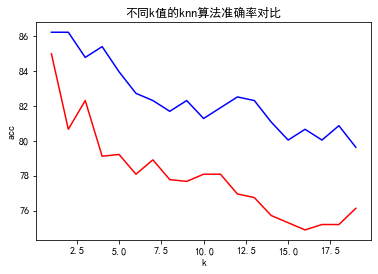

In [33]:
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
plt.xlabel('k')
plt.ylabel('acc')
plt.title('不同k值的knn算法准确率对比')
plt.plot(k_list,acc_list, color='red', label='knn')
plt.plot(k_list,add_acc_list, color='blue', label='wc_nnc')

In [39]:
tree = tree.DecisionTreeClassifier(criterion="gini")
tree.fit(newX, y_train)
score = tree.score(xx,y_test)
print('决策树训练准确率：',score*100,'%')

决策树训练准确率： 77.05761316872429 %


In [3]:
svm = sklearn.svm.SVC()                    # svm
svm.fit(newX, y_train)
y_pred_on_train_svm = svm.predict(xx)
acc_svm = metrics.accuracy_score(y_test, y_pred_on_train_svm)
print('svm训练准确度：',acc_svm*100,'%')

svm训练准确度： 85.59670781893004 %
